In [1]:
#https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE#dependencies_prerequisites
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K


input_shape = (50, 50, 3)
num_features = 7500#50*50*3
latent_dim = 512

In [2]:
def sampling(args):
    """Reparameterization trick. Instead of sampling from Q(z|X), 
    sample eps = N(0,I) z = z_mean + sqrt(var)*eps.

    Parameters:
    -----------
    args: list of Tensors
        Mean and log of variance of Q(z|X)

    Returns
    -------
    z: Tensor
        Sampled latent vector
    """

    z_mean, z_log_var = args
    eps = tf.random.normal(tf.shape(z_log_var), dtype=tf.float32, mean=0., stddev=1.0, name='epsilon')
    z = z_mean + tf.exp(z_log_var / 2) * eps
    return z

In [3]:
base_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(50, 50, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

2022-04-23 16:33:53.025834: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
def encoder_CNN(input_shape = (50, 50, 3), latent_dim = 2):

    inputs = layers.Input(shape=input_shape,name='Input')
    #block 1
    x = base_model.get_layer('block1_conv1')(inputs)
    x.trainable=False

    x = base_model.get_layer('block1_conv2')(x)
    x.trainable=False

    # block 2
    x = layers.Conv2D(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2,name='S4')(x)
    
    x = layers.BatchNormalization()(x)
    # block 3
    x = layers.Conv2D(16, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(16, (3, 3),
                    activation='relu',
                    padding='same',
                    name='block3_conv2')(x)    
                    
    x = layers.Conv2D(filters=3, kernel_size=5,strides=1,padding='same')(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(25*25*3)(x)
    y = layers.Dense(latent_dim * 2)(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(y)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(y)
    z = layers.Lambda(sampling, name='z')([z_mean, z_log_var]) #reparametrization trick
    model = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    
    return model
    

In [5]:
def encoder_CNN(input_shape = (50, 50, 3), latent_dim = 2): #best

    inputs = layers.Input(shape=input_shape,name='Input')
    #block 1
    x = base_model.get_layer('block1_conv1')(inputs)
    x.trainable=False

    x = base_model.get_layer('block1_conv2')(x)
    x.trainable=False

    # block 2
    x = layers.Conv2D(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2,name='S4')(x)
    
    x = layers.BatchNormalization()(x)
    # block 3
    x = layers.Conv2D(16, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(16, (3, 3),
                    activation='relu',
                    padding='same',
                    name='block3_conv2')(x)    
                    
    y = layers.Conv2D(filters=3, kernel_size=5,strides=1,padding='same')(x)
    
    z_mean = layers.Dense(3, name='z_mean')(y)
    z_log_var = layers.Dense(3, name='z_log_var')(y)
    z = layers.Lambda(sampling, name='z')([z_mean, z_log_var]) #reparametrization trick
    model = keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')
    
    return model
    

In [22]:
encoder = encoder_CNN(latent_dim = latent_dim)
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 50, 50, 64)   1792        ['Input[0][0]']                  
                                                                                                  
 block1_conv2 (Conv2D)          (None, 50, 50, 64)   36928       ['block1_conv1[6][0]']           
                                                                                                  
 block2_conv1 (Conv2D)          (None, 50, 50, 32)   18464       ['block1_conv2[6][0]']           
                                                                                            

In [25]:
def decoder_CNN( latent_dim = 2):
    latent_inputs = layers.Input(shape=(latent_dim, ), name='z_sampling')
    x = layers.Dense(25*25*3)(latent_inputs) # if latent_dim < 25*25*3
    x = layers.Reshape(target_shape=(25, 25, 3))(x)
    x = layers.Conv2DTranspose(16, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block4_conv1')(x)
    x = layers.Conv2DTranspose(16, (3, 3),
                    activation='relu',
                    padding='same',
                    name='up_block4_conv2')(x)  
    x = layers.BatchNormalization()(x)
    # block 2
    x = layers.Conv2DTranspose(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block5_conv1')(x)
    x = layers.Conv2DTranspose(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block5_conv2')(x)
 
    x = layers.UpSampling2D()(x)
    
    
    x = layers.Conv2DTranspose(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block6_conv1')(x)
                      
    outputs = layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, activation='sigmoid',padding='same')(x)
   # outputs = layers.Reshape(target_shape=(50, 50, 3), name='output')(x)
    model = keras.Model(latent_inputs, outputs, name='decoder')
    return model

In [8]:
def decoder_CNN( latent_dim = 2): #best
    latent_inputs = layers.Input(shape=(25, 25, 3), name='z_sampling')

    x = layers.Conv2DTranspose(16, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block4_conv1')(latent_inputs)
    x = layers.Conv2DTranspose(16, (3, 3),
                    activation='relu',
                    padding='same',
                    name='up_block4_conv2')(x)  
    
    # block 2
    x = layers.Conv2DTranspose(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block5_conv1')(x)
    x = layers.Conv2DTranspose(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block5_conv2')(x)
    x = layers.UpSampling2D()(x)
    
    
    x = layers.Conv2DTranspose(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block6_conv1')(x)
                      
    outputs = layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, activation='sigmoid',padding='same')(x)
   # outputs = layers.Reshape(target_shape=(50, 50, 3), name='output')(x)
    model = keras.Model(latent_inputs, outputs, name='decoder')
    return model

In [26]:
decoder = decoder_CNN(latent_dim = latent_dim)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 512)]             0         
                                                                 
 dense_9 (Dense)             (None, 1875)              961875    
                                                                 
 reshape_1 (Reshape)         (None, 25, 25, 3)         0         
                                                                 
 up_block4_conv1 (Conv2DTran  (None, 25, 25, 16)       448       
 spose)                                                          
                                                                 
 up_block4_conv2 (Conv2DTran  (None, 25, 25, 16)       2320      
 spose)                                                          
                                                                 
 batch_normalization_7 (Batc  (None, 25, 25, 16)       64  

In [27]:
def vae(input_shape, latent_dim, encoder, decoder):
    vae_input = layers.Input(shape = input_shape, name="VAE_input")

    encoder = encoder_CNN(latent_dim = latent_dim)
 

    decoder = decoder_CNN(latent_dim = latent_dim)
   

    vae = keras.Model(encoder.input, decoder(encoder.output[2]), name='VAE')
    return vae, encoder, decoder

In [28]:
vae, vae_encoder, vae_decoder = vae(input_shape, latent_dim, encoder, decoder)

In [29]:
vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 50, 50, 64)   1792        ['Input[0][0]']                  
                                                                                                  
 block1_conv2 (Conv2D)          (None, 50, 50, 64)   36928       ['block1_conv1[7][0]']           
                                                                                                  
 block2_conv1 (Conv2D)          (None, 50, 50, 32)   18464       ['block1_conv2[7][0]']           
                                                                                                

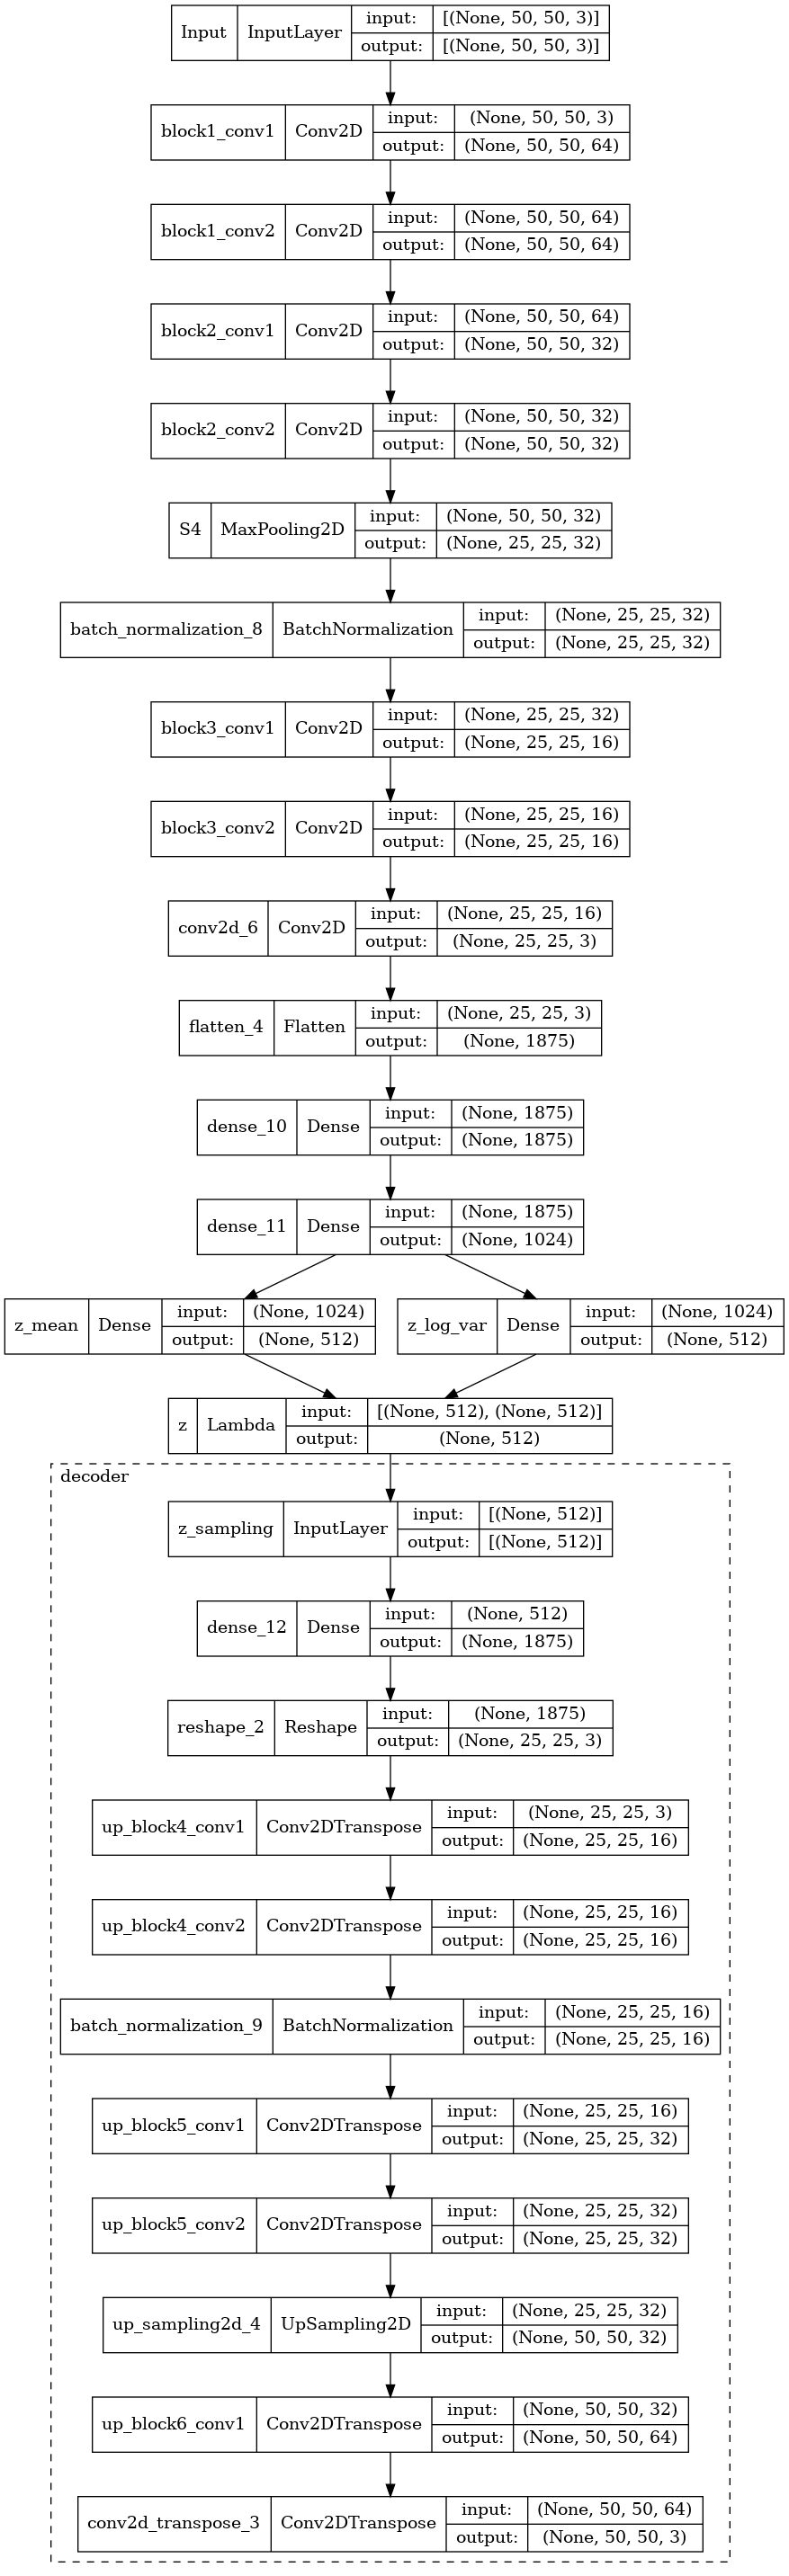

In [30]:
plot_model(vae,show_shapes=True, show_layer_names=True,expand_nested=True)

In [14]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        #self.beta_coefficient = beta_coefficient
    
    def call(self, inputs):
        x = self.encoder(inputs)[2]
        return self.decoder(x)
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_sum(
                    keras.losses.MSE(data, reconstruction), axis=(1, 2) # mod
                )
           # )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + (self.beta * kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [15]:

vae = VAE(encoder, decoder)

TypeError: __init__() missing 1 required positional argument: 'beta'

In [ ]:
vae.compile(optimizer='adam')


In [31]:
#vae.save('models/vae.h5')  
encoder.save('models/vae_encoder.h5')
decoder.save('models/vae_decoder.h5')

In [ ]:
#condtional vae
class CVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(CVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def conditional_input(self, inputs, image_size=[50,50,3], label_size=2): #inputs should be a 2 dim array
        input_img = layers.InputLayer(input_shape=image_size, dtype ='float32')(inputs[0])
        input_label = layers.InputLayer(input_shape=(label_size, ), dtype ='float32')(inputs[1])
        labels = tf.reshape(inputs[1], [-1, 1, 1, label_size]) #batch_size, 1, 1, label_size
        labels = tf.cast(labels, dtype='float32')
        ones = tf.ones([inputs[0].shape[0]] + image_size[0:-1] + [label_size]) #batch_size, 50, 50, label_size
        labels = ones * labels #batch_size, 50, 50, label_size
        conditional_input = layers.Concatenate(axis=3)([input_img, labels]) 
        return  input_img, input_label, conditional_input



    def train_step(self, data):
        with tf.GradientTape() as tape:
            conditional_input = self.conditional_input(data)
            z_mean, z_log_var, z_cond = self.encoder(conditional_input)
            reconstruction = self.decoder(z_cond)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.MeanSquaredError(data, reconstruction), axis=(1, 2, 3) # mod
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
def encoder_CVAE(labels=(0,1), input_shape = (50, 50, 3),  label_size=2): #best

    inputs = layers.Input(shape=(input_shape[0],
            input_shape[1], input_shape[2] + label_size), dtype='float32',name='Input')
    #inputs = layers.Input(shape = input_shape)
    #labels_inputs = layers.Input(shape = (50, 50, 2))
    #encoder_inputs = layers.Concatenate()([inputs, labels_inputs])


    #block 1
    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1')(inputs)

    x = layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2')(x)
    
    # block 2
    x = layers.Conv2D(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1')(x)
    x = layers.Conv2D(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2')(x)
    x = layers.MaxPool2D(pool_size=2, strides=2,name='S4')(x)
    
    x = layers.BatchNormalization()(x)
    # block 3
    x = layers.Conv2D(16, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1')(x)
    x = layers.Conv2D(16, (3, 3),
                activation='relu',
                padding='same',
                name='block3_conv2')(x)    
                    
    y = layers.Conv2D(filters=5, kernel_size=5,strides=1,padding='same')(x)
    
    z_mean = layers.Dense(5, name='z_mean')(y)
    z_log_var = layers.Dense(5, name='z_log_var')(y)
    z_cond = layers.Lambda(sampling, name='z')([z_mean, z_log_var]) #reparametrization trick
    model = keras.Model(inputs, [z_mean, z_log_var, z_cond], name='encoder')
    
    return model
    

In [ ]:
cvae_encoder = encoder_CVAE()
cvae_encoder.summary()

In [ ]:
def decoder_CVAE(latent_shape = (25, 25, 5), condition_count = (None, 2), latent_dim = 2): #best

    decoder_inputs = layers.Input(shape=latent_shape , name='decoder_input')
    x = layers.Conv2DTranspose(16, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block4_conv1')(decoder_inputs)
    x = layers.Conv2DTranspose(16, (3, 3),
                    activation='relu',
                    padding='same',
                    name='up_block4_conv2')(x)  
    
    # block 2
    x = layers.Conv2DTranspose(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block5_conv1')(x)
    x = layers.Conv2DTranspose(32, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block5_conv2')(x)
    x = layers.UpSampling2D()(x)
    
    
    x = layers.Conv2DTranspose(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='up_block6_conv1')(x)
                      
    outputs = layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, activation='sigmoid',padding='same')(x)
   # outputs = layers.Reshape(target_shape=(50, 50, 3), name='output')(x)
    model = keras.Model(decoder_inputs, outputs, name='decoder')
    return model

In [ ]:
cvae_decoder = decoder_CVAE()
cvae_decoder.summary()

In [ ]:
#vae.save('models/vae.h5')  
cvae_encoder.save('models/cvae_encoder.h5')
cvae_decoder.save('models/cvae_decoder.h5')

In [ ]:
def conditional_input( inputs, image_size=[50,50,3], label_size=2): #inputs should be a 2 dim array
    input_img = layers.InputLayer(input_shape=image_size, dtype ='float32')(inputs[0])
    input_label = layers.InputLayer(input_shape=(label_size, ), dtype ='float32')(inputs[1])
    labels = tf.reshape(inputs[1], [-1, 1, 1, label_size]) #batch_size, 1, 1, label_size
    labels = tf.cast(labels, dtype='float32')
    ones = tf.ones([inputs[0].shape[0]] + image_size[0:-1] + [label_size]) #batch_size, 50, 50, label_size
    labels = ones * labels #batch_size, 50, 50, label_size
    conditional_input = layers.Concatenate(axis=3)([input_img, labels]) 
    return  input_img, input_label, labels, conditional_input

In [ ]:
def reshape_labels(labels, batch_size=10, target_size = [10, 25, 25, 3]):

    labels = tf.reshape(inputs[1], [-1, 1, 1, label_size]) #batch_size, 1, 1, label_size
    labels = tf.cast(labels, dtype='float32')
    labels = tf.cast(labels, dtype='float32')
    ones = tf.ones([target_size.shape[0]] + target_size[0:-1] + [label_size]) #batch_size, 50, 50, label_size
    labels = ones * labels #batch_size, 50, 50, label_size
    return labels

In [ ]:
inputs0 = tf.random.normal(shape=(10, 50, 50 ,3))
inputs1 = (0, 1)
inputs = [inputs0, inputs1]
label_size = 2
image_size = [50, 50, 3]
_, _, labels, _ = conditional_input(inputs)

labels.shape
reshape_labels(labels)